In [14]:
%load_ext autoreload
%autoreload 2

In [1]:
from templates import *

In [2]:
device = 'cuda:0'
conf = ffhq128_autoenc_72M()
# conf = ffhq256_autoenc()
# print(conf.name)
model = LitModel(conf)
state = torch.load(f'checkpoints/{conf.name}/last.ckpt', map_location='cpu')
# state = torch.load(f'/home/coolboy/wwh/diffusion-autoencoders-main/output/latentweight/128_bs128_latent512/epoch_260_ckpt.pth', map_location='cpu')
# model.load_state_dict(state['model'], strict=False)
model.load_state_dict(state['state_dict'], strict=False)
model.ema_model.eval()
model.ema_model.to(device)
fake_average_vector = torch.load('weight/fake_mean.pth')
real_average_vector = torch.load('weight/real_mean.pth')

# fake_loaded_cond_list = torch.load('/home/coolboy/wwh/diffusion-autoencoders-main/weight/fake_conds180k.pth')
# real_loaded_cond_list = torch.load('/home/coolboy/wwh/diffusion-autoencoders-main/weight/real_conds180k.pth')

Global seed set to 0


Model params: 122.59 M


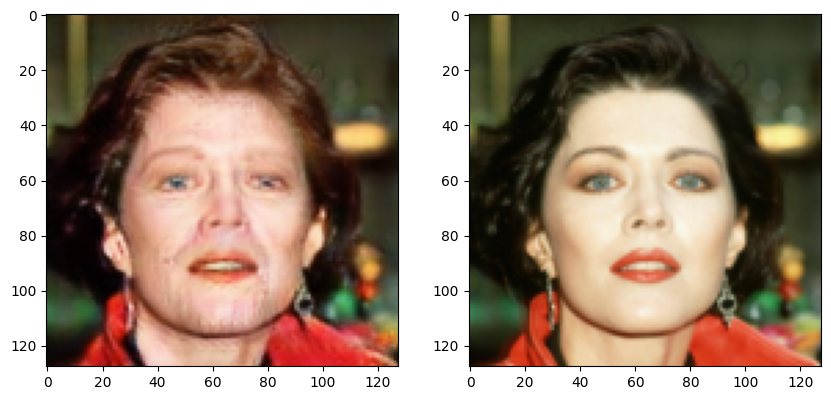

In [3]:
import matplotlib.pyplot as plt
from templates import *
data1 = ImageDataset('imgs_render/Fake', image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)
data2 = ImageDataset('imgs_render/Real', image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)
batch1 = data1[0]['img'][None]
batch2 = data2[0]['img'][None]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ori = (batch1 + 1) / 2
ax[0].imshow(batch1[0].permute([1, 2, 0]) / 2 + 0.5)
ax[1].imshow(batch2[0].permute([1, 2, 0]) / 2 + 0.5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


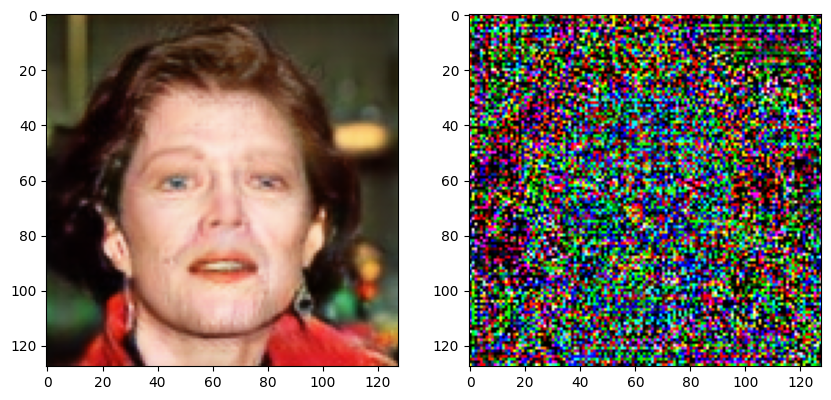

In [27]:
import matplotlib.pyplot as plt
cond1 = model.encode(batch1.to(device))
cond2 = model.encode(batch2.to(device))
device = torch.device("cuda:0")  # or whichever device you prefer

# fake_average_vector = fake_average_vector.to(device)
# real_average_vector = real_average_vector.to(device)
xT_1 = model.encode_stochastic(batch1.to(device), cond1, T=100)
# xT_2 = model.encode_stochastic(batch2.to(device), cond2, T=100)
xT_1 = xT_1.to(device)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ori = (batch1 + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(xT_1[0].permute(1, 2, 0).cpu())

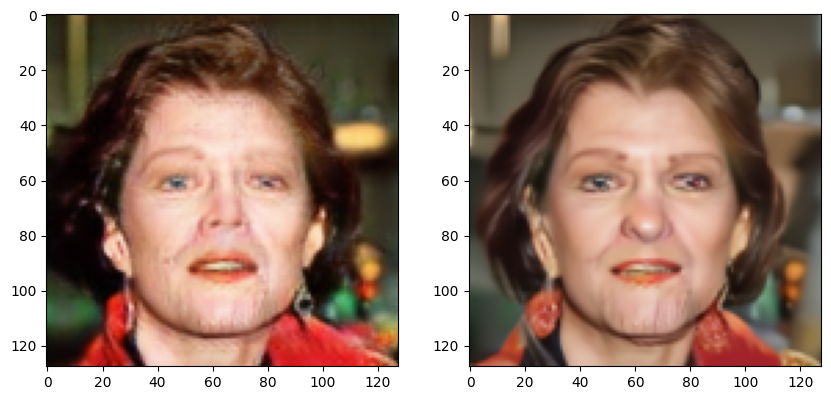

In [32]:
# Fake -> Real
from torchvision.utils import save_image

a = 0.5
b = 0.5
combine_vector = a * cond1 + b * real_average_vector

pred = model.render(xT_1, combine_vector, T=100)
# pred = model.render(xT, cond1, T=100)
# pred = model.render(xT, cond2, T=100)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ori = (batch1 + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(pred[0].permute(1, 2, 0).cpu())
# # 保存整个plt输出
# fig.savefig("/home/coolboy/wwh/diffusion-autoencoders-main/imgs_render/Fake/complete_output_image.png")

# 仅保存pred图像
save_image(pred[0], f"/home/coolboy/wwh/diffusion-autoencoders-main/imgs_render/Real/pred1.png")

In [4]:
from detector.xception_net import Xception_Net
from torchvision import transforms, datasets
from efficientnet_pytorch import EfficientNet
import torch
device = 'cuda:0'
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225] 
data_transforms = {
    'test': transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}
dir_path = '/home/coolboy/wwh/diffusion-autoencoders-main/imgs_render_t100'
batch_size = 16
test_dataset = datasets.ImageFolder(dir_path, data_transforms['test'])
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False, num_workers=0, pin_memory=True)
dataset_size = len(test_dataset)
print('size: {}'.format(dataset_size))
print('Class to index mapping:', test_dataset.class_to_idx)
classifier = Xception_Net()
classifier = EfficientNet.from_name('efficientnet-b7').to(device)
# classifier = torchvision.models.resnet50(pretrained=False).to(device)
# num_ftrs = classifier.fc.in_features
# classifier.fc = nn.Linear(num_ftrs, 2)  # 将最后一层改为输出2类
# weightpath = '/home/coolboy/wwh/diffusion-autoencoders-main/weight/128_weight/ResNet_model_best_0.9845_epoch14.pt'
weightpath = '/home/coolboy/wwh/diffusion-autoencoders-main/weight/128_weight/effnet_model_best_1.0000_epoch4.pt'
# weightpath = '/home/coolboy/wwh/diffusion-autoencoders-main/weight/128_weight/Xcep_model_best_0.9990_epoch7.pt'
check = torch.load(weightpath)
classifier.load_state_dict(check)
classifier = classifier.cuda()
classifier.eval()

for images, labels in test_loader:
   
    inputs = images.to(device)
    labels = labels.to(device)
    print('labels', labels)
    with torch.no_grad():
        output = classifier(inputs)
        print('output', output)

    _, prediction = torch.max(output, 1)
    print('pred', prediction)

size: 2000
Class to index mapping: {'Fake': 0, 'Real': 1}
labels tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
output tensor([[ 1.7886e+01,  8.0047e+00, -1.0204e-02,  ..., -1.1909e-01,
         -4.5463e-02, -2.9716e-02],
        [ 1.9086e+01,  8.6528e+00, -6.6112e-02,  ..., -6.7013e-02,
         -8.0752e-02, -1.2443e-02],
        [ 1.7883e+01,  8.6120e+00, -1.0886e-01,  ..., -1.8562e-01,
         -9.2230e-02, -1.1358e-01],
        ...,
        [ 1.5495e+01,  6.6711e+00,  1.2512e-02,  ..., -5.1424e-02,
          1.8823e-02,  8.4037e-02],
        [ 1.5447e+01,  6.7420e+00,  6.7606e-03,  ..., -5.7573e-02,
          2.5069e-02,  8.6646e-02],
        [ 1.5975e+01,  6.8871e+00, -5.6531e-03,  ..., -6.5797e-02,
          6.3447e-03,  8.9016e-02]], device='cuda:0')
pred tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
labels tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
output tensor([[ 1.5528e+01,  6.8686e+00,  3.

KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


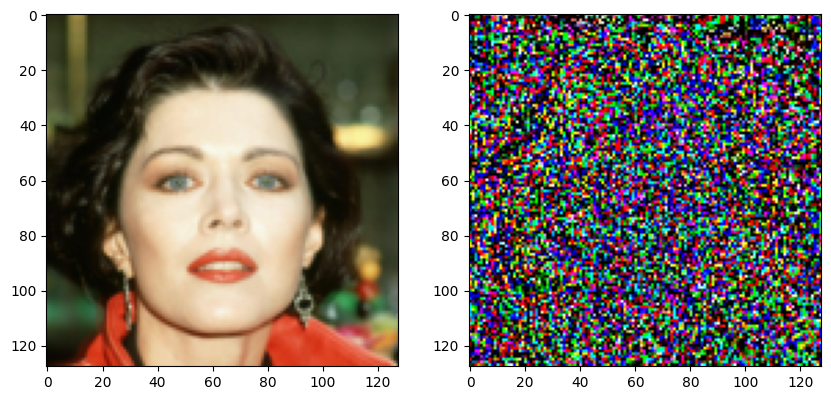

In [49]:
# real -> fake
import matplotlib.pyplot as plt
# cond1 = model.encode(batch1.to(device))
cond2 = model.encode(batch2.to(device))
device = torch.device("cuda:0")  # or whichever device you prefer
xT_2 = model.encode_stochastic(batch2.to(device), cond2, T=100)
xT_2 = xT_2.to(device)
fake_average_vector = fake_average_vector.to(device)
real_average_vector = real_average_vector.to(device)
# xT_2 = model.encode_stochastic(batch2.to(device), (cond1 + cond2) / 2, T=100)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ori = (batch2 + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(xT_2[0].permute(1, 2, 0).cpu())

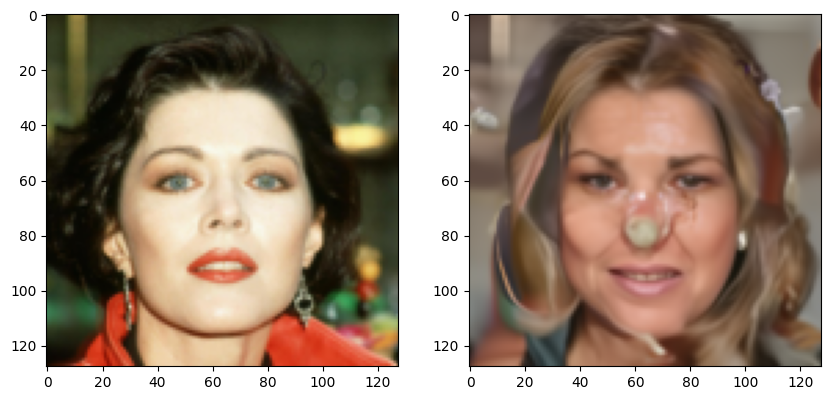

In [62]:
# Fake -> Real
from torchvision.utils import save_image

a = 0
b = 1
combine_vector = a * cond1 + b * fake_average_vector

pred = model.render(xT_2, combine_vector, T=100)
# pred = model.render(xT, cond1, T=100)
# pred = model.render(xT, cond2, T=100)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ori = (batch2 + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(pred[0].permute(1, 2, 0).cpu())
# # 保存整个plt输出
# fig.savefig("/home/coolboy/wwh/diffusion-autoencoders-main/imgs_render/Fake/complete_output_image.png")

# 仅保存pred图像
save_image(pred[0], f"/home/coolboy/wwh/diffusion-autoencoders-main/imgs_render/Real/pred1.png")

In [15]:
from detector.xception_net import Xception_Net
from torchvision import transforms, datasets
from efficientnet_pytorch import EfficientNet
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms, models
import torch
device = 'cuda:0'
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225] 
data_transforms = {
    'test': transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}
dir_path = '/home/coolboy/wwh/diffusion-autoencoders-main/imgs_render_t100_020'
batch_size = 256
test_dataset = datasets.ImageFolder(dir_path, data_transforms['test'])
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False, num_workers=0, pin_memory=True)
dataset_size = len(test_dataset)
print('size: {}'.format(dataset_size))
print('Class to index mapping:', test_dataset.class_to_idx)
# classifier = Xception_Net()
# classifier = EfficientNet.from_name('efficientnet-b7').to(device)
classifier = torchvision.models.resnet50(pretrained=False).to(device)
num_ftrs = classifier.fc.in_features
classifier.fc = nn.Linear(num_ftrs, 2)  # 将最后一层改为输出2类

# weightpath = '/home/coolboy/wwh/diffusion-autoencoders-main/weight/128_weight/Xcep_model_best_0.9990_epoch7.pt'
# weightpath = '/home/coolboy/wwh/diffusion-autoencoders-main/weight/128_weight/effnet_model_best_1.0000_epoch4.pt'
weightpath = '/home/coolboy/wwh/diffusion-autoencoders-main/weight/128_weight/ResNet_model_best_0.9845_epoch14.pt'

check = torch.load(weightpath)
classifier.load_state_dict(check)
classifier = classifier.cuda()
classifier.eval()
correct, TP, TN, FP, FN = 0, 0, 0, 0, 0
total_tested = 0
total_correct = 0
interrupt = 0
for images, labels in test_loader:
    interrupt += 1
    if interrupt == 100:
        break
    inputs = images.to(device) 
    labels = labels.to(device)
    # print('labels', labels)
    with torch.no_grad():
        output = classifier(inputs)

    _, prediction = torch.max(output, 1)
    total_tested += labels.size(0)
    total_correct += torch.sum(prediction == labels).item()
    # print('pred', prediction)
    correct = torch.sum((prediction.detach()) == labels.detach().to(torch.float32))
    TP += torch.sum((prediction == 1) & (labels == 1))
    TN += torch.sum((prediction == 0) & (labels == 0))
    FP += torch.sum((prediction == 1) & (labels == 0))
    FN += torch.sum((prediction == 0) & (labels == 1))

    
    precision = TP.float() / (TP + FP).float()
    recall = TP.float() / (TP + FN).float()
    f1_score = 2 * (precision * recall) / (precision + recall)

    print('Testing {}:[{}/{} ({:.0f}%)] Acc: {}%'.format(interrupt, interrupt*batch_size, dataset_size,
                                                        100. * interrupt*batch_size / dataset_size,
                                                        correct / (batch_size) * 100))

print('True Positives: {}, True Negatives: {}, False Positives: {}, False Negatives: {}'.format(TP, TN, FP, FN))
# print('Precision: {:.4f}, Recall: {:.4f}, F1-score: {:.4f}， Acc: {:.4f}, ASR: {:.4f}'.format(precision, recall, f1_score, TN/1000 ,FP/1000))
print('Pre-Acc {:.4f}， After-Acc: {:.4f}, ASR: {:.4f}'.format(FN/10, TN/10 ,FP/10))
avg_accuracy = total_correct / total_tested
print('Average Accuracy: {:.2f}%'.format(avg_accuracy * 100))

size: 2000
Class to index mapping: {'Fake': 0, 'Real': 1}
Testing 1:[256/2000 (13%)] Acc: 16.796875%
Testing 2:[512/2000 (26%)] Acc: 17.96875%
Testing 3:[768/2000 (38%)] Acc: 13.28125%
Testing 4:[1024/2000 (51%)] Acc: 14.84375%
Testing 5:[1280/2000 (64%)] Acc: 0.390625%
Testing 6:[1536/2000 (77%)] Acc: 0.0%
Testing 7:[1792/2000 (90%)] Acc: 0.390625%
Testing 8:[2048/2000 (102%)] Acc: 0.78125%
True Positives: 4, True Negatives: 161, False Positives: 839, False Negatives: 996
Pre-Acc 99.6000， After-Acc: 16.1000, ASR: 83.9000
Average Accuracy: 8.25%
